<a href="https://colab.research.google.com/github/IA2021UR/trabajo-ia-en-la-comunidad-de-la-rioja-equipo-2/blob/main/RESULTADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Trabajo IA en la comunidad de La Rioja, equipo 2
Dataset: https://unirioja-my.sharepoint.com/:u:/g/personal/joheras_unirioja_es/EbmPj-gacuJMrllR3FsP1IcBSvAh5dDfD7VdZQDkyWjMNA?e=qAKxPT 

##Librerías utilizadas


In [13]:
!pip install pymupdf             #Para el conversor de PDF a Imagen
import fitz                      #Para el conversor de PDF a Imagen
import cv2                       #Para tratamiento de imagenes
import matplotlib.pyplot as plt  #Para mostrar las imagenes
import imutils                   #Para alinear imágenes
from collections import namedtuple #Para las localizaciones ocr
import numpy as np    


##Función mostrar imagen


In [3]:
def mostrarImagen(image):
    if len(image.shape)==3:
        img2 = image[:,:,::-1]
        plt.figure(figsize = (200,20))
        plt.imshow(img2)
        plt.show()
    else:
        img2 = image
        plt.figure(figsize = (180,18))
        plt.imshow(img2,cmap='gray')
        plt.show()

##Conversor de PDF a Imagen

In [4]:
#La función recibe tres strings, convierte el fichero x.pdf en dos imágenes x_0.png y x_1.png (Una por cada página)
def conversorPDF_PNG(nombreFichero, pathOrigen, pathDestino):
  doc = fitz.open(pathOrigen+nombreFichero)
  for pg in range(doc.pageCount):
        page = doc[pg]
        rotate = int(0)
            # El factor de escala para cada tamaño es 2, lo que generará una imagen con cuatro veces la resolución para nosotros.
        zoom_x = 2.0
        zoom_y = 2.0
        trans = fitz.Matrix(zoom_x, zoom_y).preRotate(rotate)
        pm = page.getPixmap(matrix=trans, alpha=False)
        nombreFichero=nombreFichero.split('.')[0]
        name = nombreFichero+"_"+str(pg)+".png"
        pm.writePNG(pathDestino+name)


##Función para alinear imágenes

In [5]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15

def alignImages(im1, im2):

  # Convert images to grayscale
  im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
  im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

  # Detect ORB features and compute descriptors.
  orb = cv2.ORB_create(MAX_FEATURES)
  keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
  keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

  # Match features.
  matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
  matches = matcher.match(descriptors1, descriptors2, None)

  # Sort matches by score
  matches.sort(key=lambda x: x.distance, reverse=False)

  # Remove not so good matches
  numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
  matches = matches[:numGoodMatches]

  # Draw top matches
  imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
  cv2.imwrite("matches.jpg", imMatches)

  # Extract location of good matches
  points1 = np.zeros((len(matches), 2), dtype=np.float32)
  points2 = np.zeros((len(matches), 2), dtype=np.float32)

  for i, match in enumerate(matches):
    points1[i, :] = keypoints1[match.queryIdx].pt
    points2[i, :] = keypoints2[match.trainIdx].pt

  # Find homography
  h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

  # Use homography
  height, width, channels = im2.shape
  im1Reg = cv2.warpPerspective(im1, h, (width, height))

  return im1Reg

##Concatenar imágenes

In [6]:
def concatenarImagenes(img1, img2): 
  return cv2.vconcat([img1, img2])

##Instrucciones


In [32]:

#Convertimos a png el documento y la plantilla que vamos a utilizar:
conversorPDF_PNG('fichero.pdf','','')

fichero1=cv2.imread("fichero_0.png")
fichero2=cv2.imread("fichero_1.png")

plantilla1=cv2.imread("plantilla_0.png")
plantilla2=cv2.imread("plantilla_1.png")

fichero = concatenarImagenes(fichero1,fichero2)
plantilla = concatenarImagenes(plantilla1,plantilla2)

alineada=alignImages(fichero,plantilla)


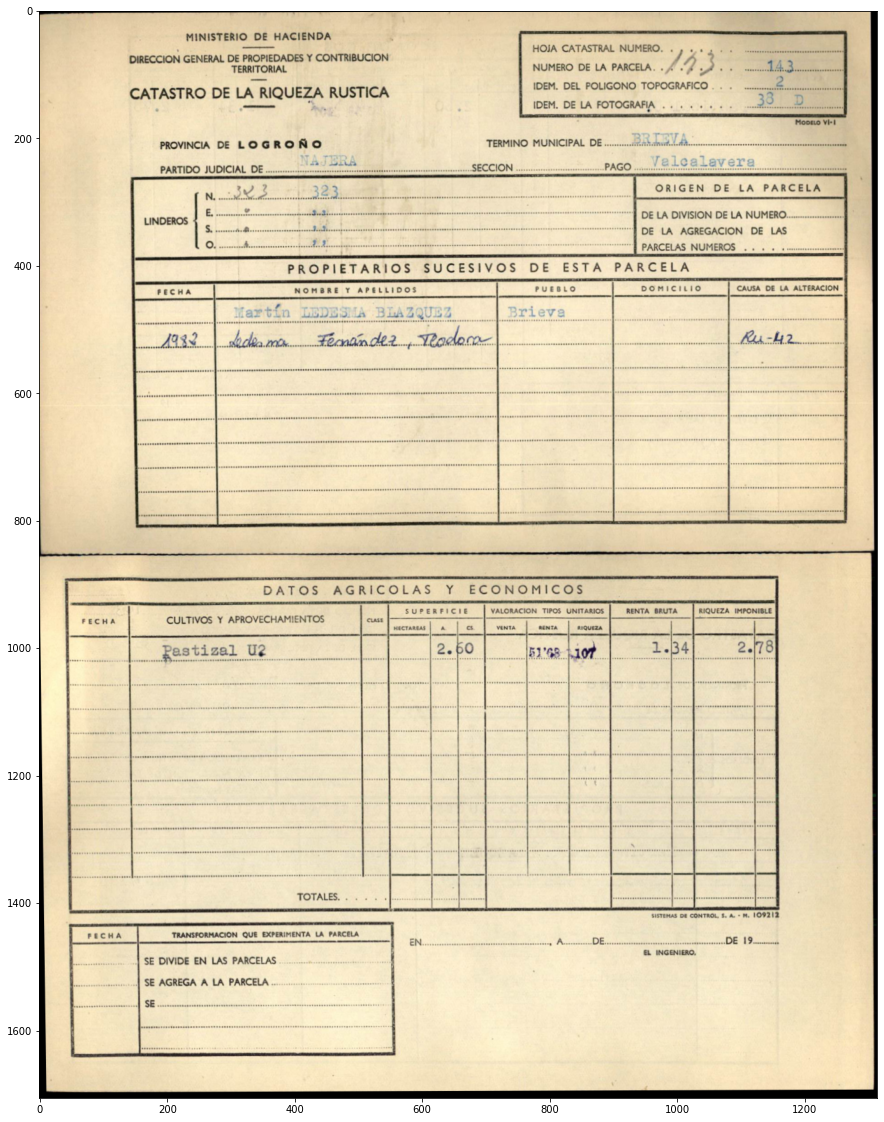

In [33]:
mostrarImagen(alineada)


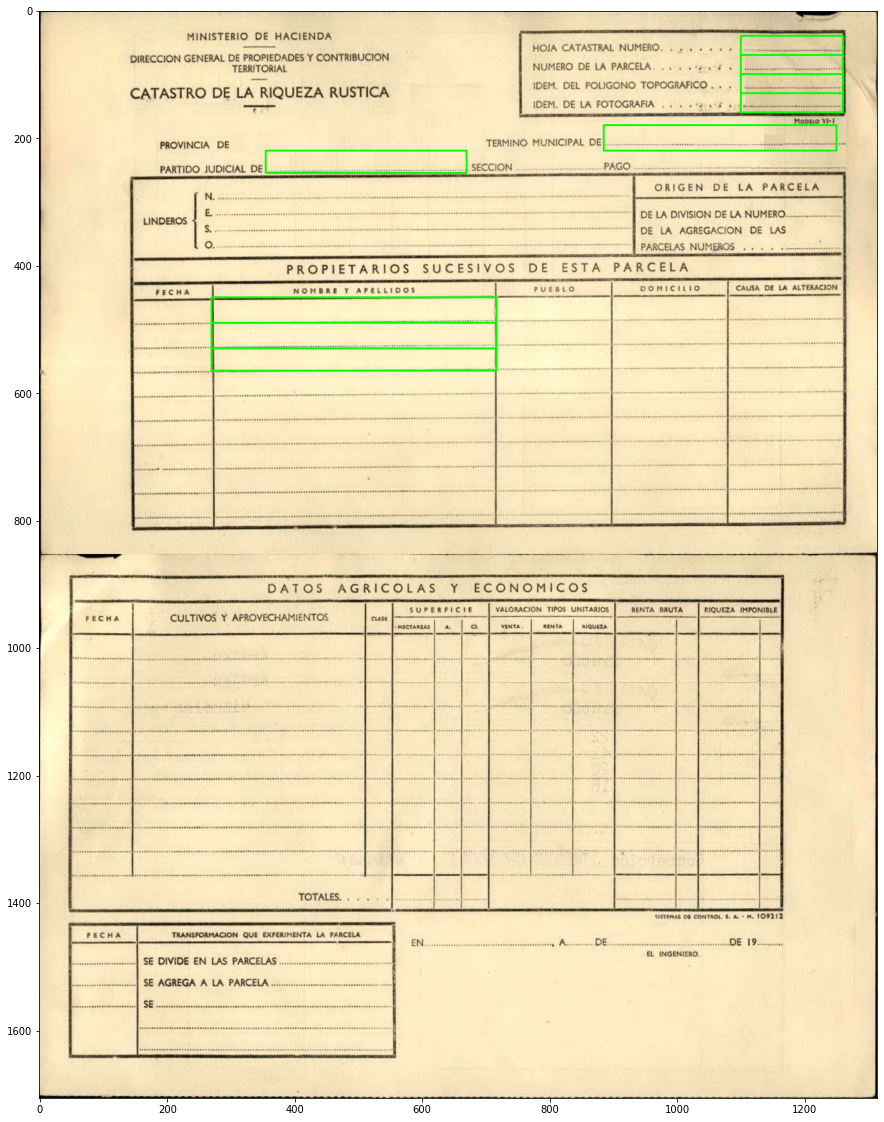

In [59]:
clone=plantilla.copy()
cv2.rectangle(clone, (885, 180), (1250, 220), (0, 255, 0), 2) #Termino municipal de
cv2.rectangle(clone, (355, 220), (670, 255), (0, 255, 0), 2) #Partido judicial de

cv2.rectangle(clone, (1100, 40), (1260, 70), (0, 255, 0), 2) #Hoja catastral número
cv2.rectangle(clone, (1100, 70), (1260, 100), (0, 255, 0), 2) #número de la parcela
cv2.rectangle(clone, (1100, 100), (1260, 130), (0, 255, 0), 2) #idem del poligono topográfico
cv2.rectangle(clone, (1100, 130), (1260, 160), (0, 255, 0), 2) #idem de la fotografía

cv2.rectangle(clone, (270, 450), (717, 490), (0, 255, 0), 2) #Propietario1
cv2.rectangle(clone, (270, 490), (717, 530), (0, 255, 0), 2) #Propietario2
cv2.rectangle(clone, (270, 530), (717, 565), (0, 255, 0), 2) #Propietario3
mostrarImagen(clone)

De aqui para bajo está sin hacer

In [30]:
#Definimos la posición de las localizaciones que queremos leer
OCRLocation = namedtuple ( "OCRLocation" , [ "id" , "bbox" ])
OCR_Locations=[
    OCRLocation("termino municipal",(940,185,310,40)),
    OCRLocation("partido judicial",(380,225,300,45)),
    OCRLocation("numero de parcela",(1150,68,150,31)),
    OCRLocation("cultivos 1",(155,1020,380,40)),
    OCRLocation("cultivos 2",(155,1060,380,40)),
    OCRLocation("cultivos 3",(155,1100,380,40))
    ]

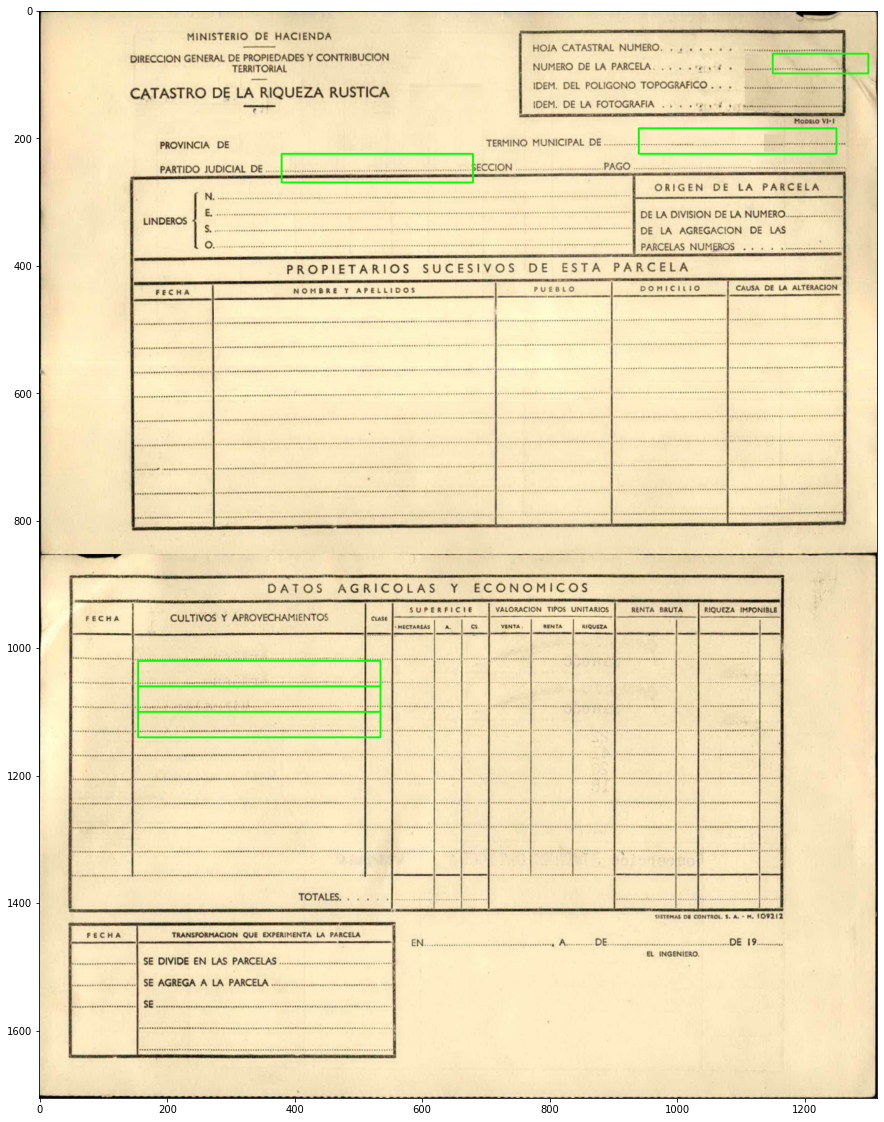

In [38]:
#Mostramos dichas localizaciones solo para ver si son correctas:
copy=plantilla.copy()
for location in OCR_Locations:
  (x,y,w,h)=location.bbox
  cv2.rectangle(copy,(x,y),(x+w,y+h),(0,255,0,2),2)
mostrarImagen(copy)

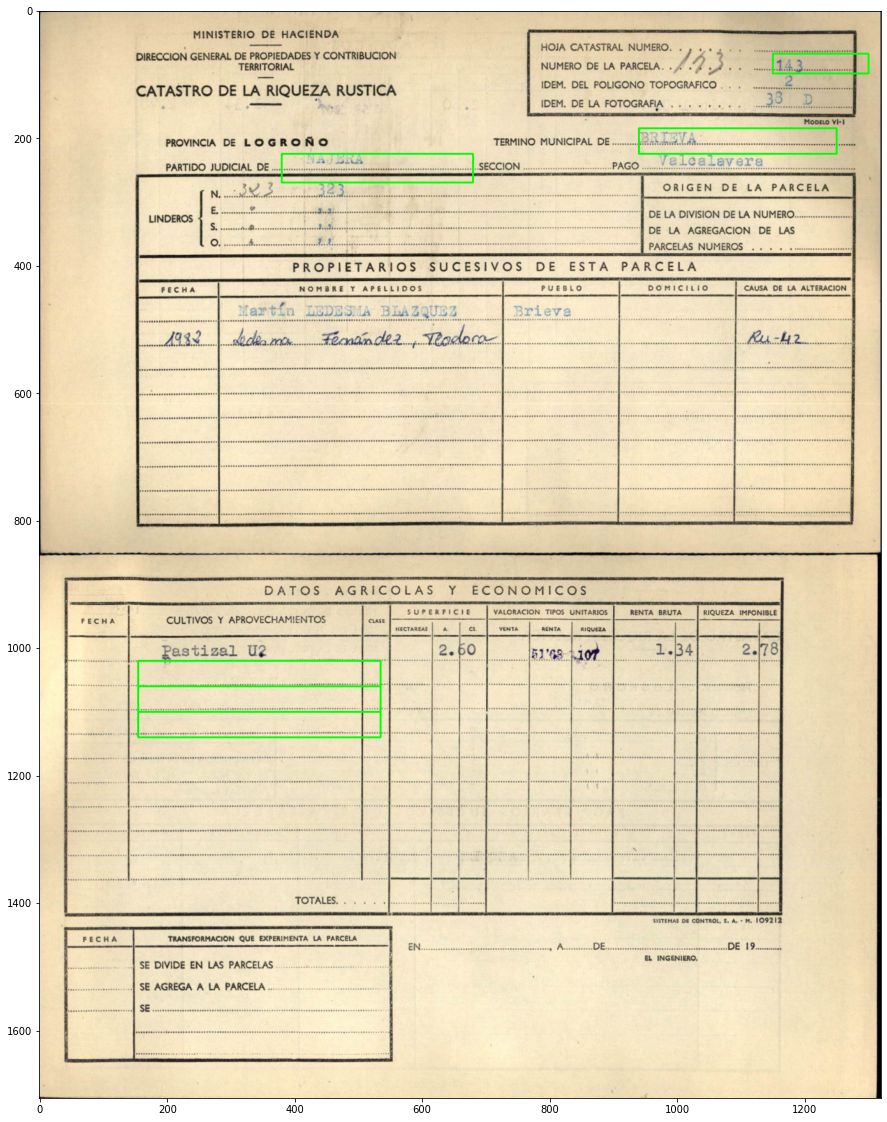

In [35]:
#Mostramos dichas localizaciones solo para ver si son correctas:
copy=fichero.copy()
for location in OCR_Locations:
  (x,y,w,h)=location[1]
  cv2.rectangle(copy,(x,y),(x+w,y+h),(0,255,0),2)
mostrarImagen(copy)

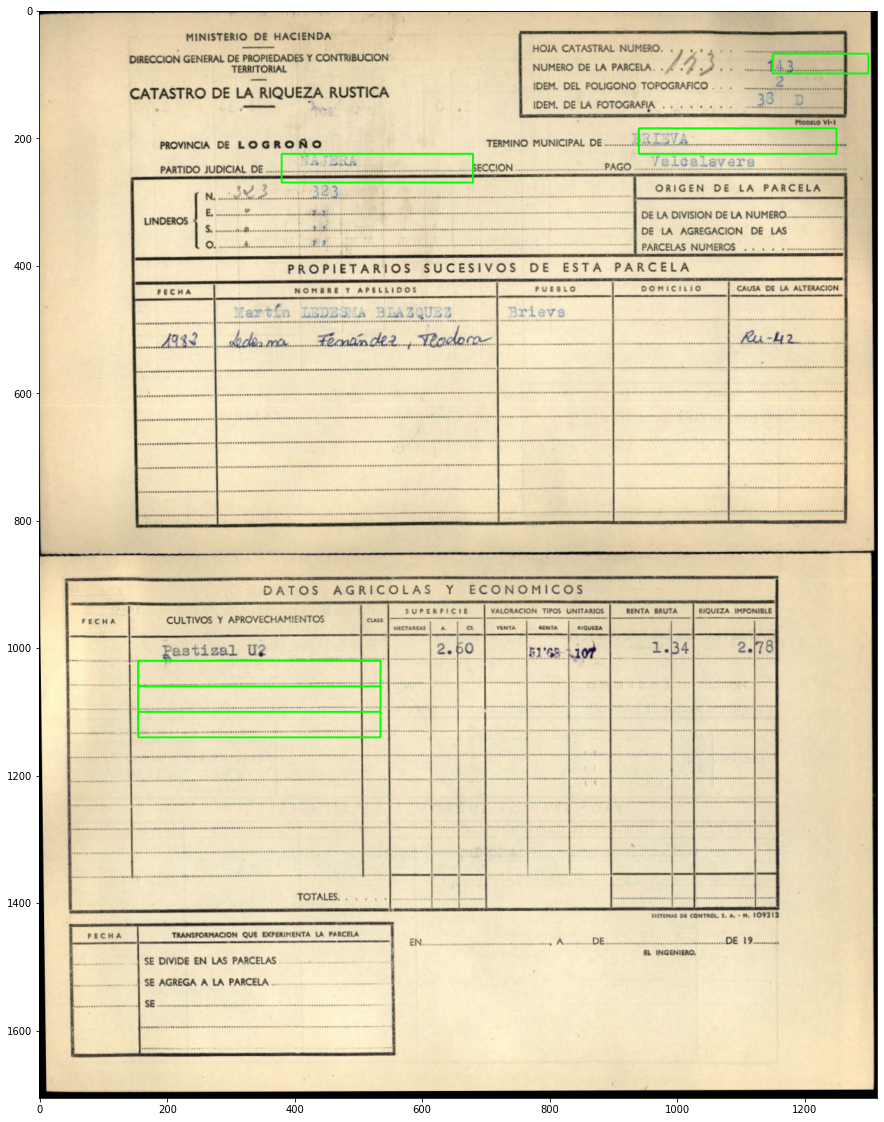

In [34]:
#Mostramos dichas localizaciones solo para ver si son correctas:
copy=alineada.copy()
for location in OCR_Locations:
  (x,y,w,h)=location[1]
  cv2.rectangle(copy,(x,y),(x+w,y+h),(0,255,0),2)
mostrarImagen(copy)